In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from ipywidgets import interact
import pymongo

In [ ]:
def load_stacks(beamline : str , sample_name : str , scan_type : str):
    client = pymongo.MongoClient('mongodb://localhost/')
    db = client['in_situ_fluo']
    stack_coll = db['stacks']
    query = {}
    
    query['beamline'] = beamline
    
    query['sample_name'] = sample_name
    
    query['scan_type'] = scan_type
        
    stack_docs = stack_coll.find(query)
    element_names = ['Mn_Ka', 'Cr_Ka']

In [3]:
#configs
root_path = "/media/lazari/Al_AM_P06/process/"
sample_name = "08_alloy_C_lamella_A_roco"
lookup_t = pd.read_excel(r"/media/lazari/Al_AM_P06/logbook_look_up_table.xlsx",
    sheet_name='Alloy C Lamella A')
scan_detail = 'jmesh ROI2'
exclude_scan_nrs = np.array([400])
scan_nrs = lookup_t['Scan Number'][lookup_t['Scan details'] == scan_detail]
hours = np.array(lookup_t['Time (hrs)'][lookup_t['Scan details'] == scan_detail])
temps = np.array(lookup_t['Temperature'][lookup_t['Scan details'] == scan_detail])
temperature = 375
mask = np.logical_and( ~scan_nrs.isin(exclude_scan_nrs), temps==375)

scan_nrs = scan_nrs[mask]
hours = hours[mask]
temps = temps[mask]



images = {'Al-Ka' : None , 'Mn_Ka' : None, 'Cr_Ka' : None}

for element in images:  
    images[element] = []
    folder_path = os.path.join(root_path,sample_name, 'fluo_stacks', scan_detail, element, 'aligned_cv2')
    for s in scan_nrs[:]:
        images[element].append(read_tiff(os.path.join(folder_path,  f'{s}.tif')))

In [4]:

from matplotlib.patches import Rectangle
vmin =0
vmax = 200
col_roi = 40
row_roi = 130
box_width = 5
@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,1000, 1), vmax=(10,1000,1),row_roi=(0, images['Mn_Ka'][0].shape[0], 1), col_roi=(0,images['Mn_Ka'][0].shape[1], 1))

def plot_im(im_nr, element, vmin , vmax, row_roi, col_roi):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    ax = plt.gca()
    
    ax.add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False))
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=11, description='im_nr', max=23), Dropdown(description='element', option…

In [5]:
rois = {
    'ROI1' : (42,71),
    'ROI2' : (37, 60),
    'ROI3' : (37, 51),
    'ROI4' : (38, 38),
    'ROI5' : (60, 60),
    'ROI6' : (47, 37)
  
    
}

#'ROI5' : (27, 17),


In [6]:
df = pd.DataFrame(columns=list(images.keys()), index=list(rois.keys()))



for element in list(df.columns):
    
    
    for roi in list(df.index):
        df[element][roi] = []
        for im in images[element]:
            
            inten = im[rois[roi][0]:rois[roi][0]+box_width, rois[roi][1]:rois[roi][1]+box_width]
       
            df[element][roi].append(inten.sum())
        df[element][roi] = np.array(df[element][roi])
        

In [7]:
df

,Al-Ka,Mn_Ka,Cr_Ka
ROI1,"[128.79012, 129.92055, 125.78465, 132.00362, 1...","[2600.6196, 2668.8164, 4149.07, 4840.8022, 504...","[389.42404, 387.5362, 408.22668, 421.36368, 41..."
ROI2,"[130.04431, 130.24815, 128.05397, 129.3239, 12...","[2622.8523, 2563.609, 2396.2334, 2066.1458, 19...","[387.02893, 395.00113, 385.70993, 370.72675, 3..."
ROI3,"[129.36894, 130.53676, 129.26604, 129.0458, 13...","[2732.3745, 2725.8855, 2696.378, 2587.5999, 21...","[402.1796, 398.2978, 404.9809, 400.77853, 381...."
ROI4,"[130.68184, 124.18331, 126.10835, 126.399536, ...","[2520.479, 2602.271, 2417.3818, 2361.0251, 232...","[385.84628, 394.18774, 380.06863, 376.9112, 38..."
ROI5,"[132.63824, 126.12036, 128.01714, 132.15555, 1...","[2722.1873, 2746.2163, 2754.5947, 2481.7952, 2...","[414.35144, 405.1243, 407.1321, 394.42984, 496..."
ROI6,"[126.930664, 127.510895, 128.67072, 125.23765,...","[2501.915, 2482.825, 2446.863, 2464.7512, 2411...","[396.99258, 395.80704, 382.1601, 384.5583, 392..."


Fractions

In [8]:
df['total'] =None
for roi in list(df.index):
    df['total'][roi] = np.zeros(len(hours))
    for element in list(df.columns)[0:-1]:
        df['total'][roi] += df[element][roi]

In [9]:
df

,Al-Ka,Mn_Ka,Cr_Ka,total
ROI1,"[128.79012, 129.92055, 125.78465, 132.00362, 1...","[2600.6196, 2668.8164, 4149.07, 4840.8022, 504...","[389.42404, 387.5362, 408.22668, 421.36368, 41...","[3118.833786010742, 3186.273147583008, 4683.08..."
ROI2,"[130.04431, 130.24815, 128.05397, 129.3239, 12...","[2622.8523, 2563.609, 2396.2334, 2066.1458, 19...","[387.02893, 395.00113, 385.70993, 370.72675, 3...","[3139.925537109375, 3088.858169555664, 2909.99..."
ROI3,"[129.36894, 130.53676, 129.26604, 129.0458, 13...","[2732.3745, 2725.8855, 2696.378, 2587.5999, 21...","[402.1796, 398.2978, 404.9809, 400.77853, 381....","[3263.923049926758, 3254.7200469970703, 3230.6..."
ROI4,"[130.68184, 124.18331, 126.10835, 126.399536, ...","[2520.479, 2602.271, 2417.3818, 2361.0251, 232...","[385.84628, 394.18774, 380.06863, 376.9112, 38...","[3037.007125854492, 3120.6420516967773, 2923.5..."
ROI5,"[132.63824, 126.12036, 128.01714, 132.15555, 1...","[2722.1873, 2746.2163, 2754.5947, 2481.7952, 2...","[414.35144, 405.1243, 407.1321, 394.42984, 496...","[3269.1769409179688, 3277.460968017578, 3289.7..."
ROI6,"[126.930664, 127.510895, 128.67072, 125.23765,...","[2501.915, 2482.825, 2446.863, 2464.7512, 2411...","[396.99258, 395.80704, 382.1601, 384.5583, 392...","[3025.8382873535156, 3006.1428833007812, 2957...."


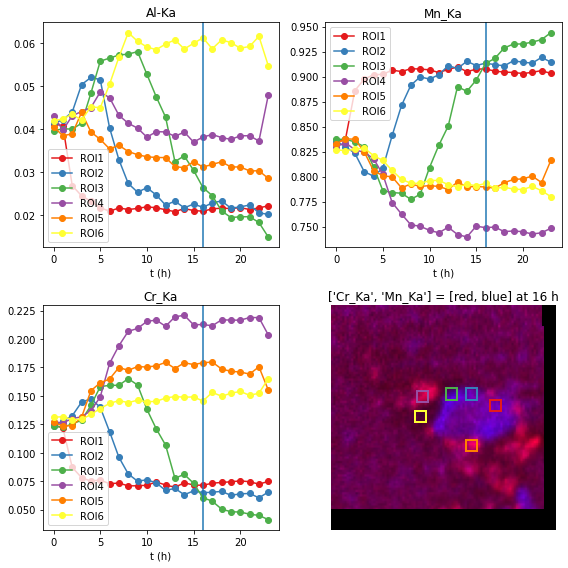

In [10]:
from matplotlib import cm
element_choice =['Cr_Ka', 'Mn_Ka']  
hour = 16
hour_idx = np.argmin(np.abs(hour-hours))

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(8,8))
axs = fig.subplots(2,2)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[0:-1]):
    for idx2, roi in enumerate(list(df.index)):

        axs[idx1].plot(hours,df[element][roi]/df['total'][roi], '-o', label=roi, color=cmap[idx2])
    axs[idx1].set_title(element)
    axs[idx1].set_xlabel('t (h)')
    axs[idx1].legend()
    axs[idx1].axvline(hours[hour_idx])

rgb_image = np.zeros(shape=images['Al-Ka'][0].shape +  (3,))
im1 = images[element_choice[0]][hour_idx]/images['Al-Ka'][hour_idx]
im2 = images[element_choice[1]][hour_idx]/images['Al-Ka'][hour_idx]

rgb_image[:,:,0] = im1/np.nanmax(im1)
rgb_image[:,:,2] = im2/np.nanmax(im2)
axs[3].imshow(rgb_image)
for idx, roi in enumerate(rois):
    row_roi = rois[roi][0]
    col_roi = rois[roi][1]
    axs[3].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[idx], linewidth=2))
    axs[3].axis('off')
    axs[3].set_title(f'{element_choice} = [red, blue] at {hours[hour_idx]} h')
    
plt.tight_layout()

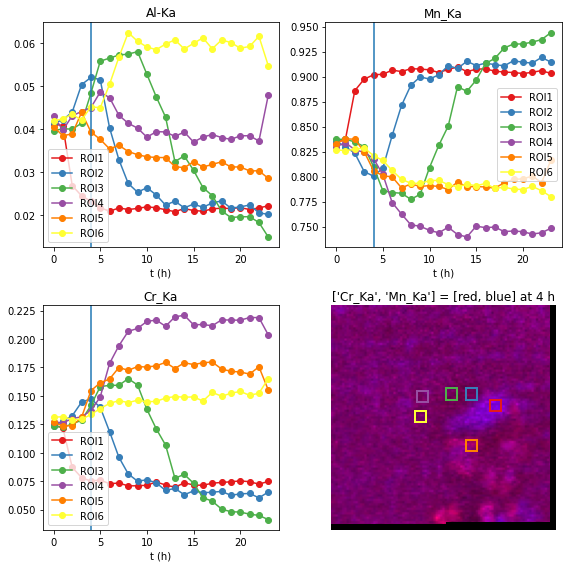

In [11]:
from matplotlib import cm
element_choice =['Cr_Ka', 'Mn_Ka']  
hour = 4
hour_idx = np.argmin(np.abs(hour-hours))

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(8,8))
axs = fig.subplots(2,2)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[0:-1]):
    for idx2, roi in enumerate(list(df.index)):

        axs[idx1].plot(hours,df[element][roi]/df['total'][roi], '-o', label=roi, color=cmap[idx2])
    axs[idx1].set_title(element)
    axs[idx1].set_xlabel('t (h)')
    axs[idx1].legend()
    axs[idx1].axvline(hours[hour_idx])

rgb_image = np.zeros(shape=images['Al-Ka'][0].shape +  (3,))
im1 = images[element_choice[0]][hour_idx]/images['Al-Ka'][hour_idx]
im2 = images[element_choice[1]][hour_idx]/images['Al-Ka'][hour_idx]

rgb_image[:,:,0] = im1/np.nanmax(im1)
rgb_image[:,:,2] = im2/np.nanmax(im2)
axs[3].imshow(rgb_image)
for idx, roi in enumerate(rois):
    row_roi = rois[roi][0]
    col_roi = rois[roi][1]
    axs[3].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[idx], linewidth=2))
    axs[3].axis('off')
    axs[3].set_title(f'{element_choice} = [red, blue] at {hours[hour_idx]} h')
    
plt.tight_layout()

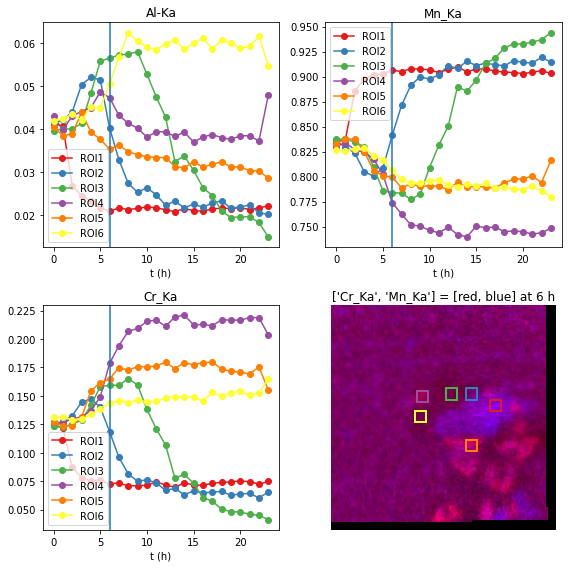

In [12]:
from matplotlib import cm
element_choice =['Cr_Ka', 'Mn_Ka']  
hour = 6
hour_idx = np.argmin(np.abs(hour-hours))

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(8,8))
axs = fig.subplots(2,2)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[0:-1]):
    for idx2, roi in enumerate(list(df.index)):

        axs[idx1].plot(hours,df[element][roi]/df['total'][roi], '-o', label=roi, color=cmap[idx2])
    axs[idx1].set_title(element)
    axs[idx1].set_xlabel('t (h)')
    axs[idx1].legend()
    axs[idx1].axvline(hours[hour_idx])

rgb_image = np.zeros(shape=images['Al-Ka'][0].shape +  (3,))
im1 = images[element_choice[0]][hour_idx]/images['Al-Ka'][hour_idx]
im2 = images[element_choice[1]][hour_idx]/images['Al-Ka'][hour_idx]

rgb_image[:,:,0] = im1/np.nanmax(im1)
rgb_image[:,:,2] = im2/np.nanmax(im2)
axs[3].imshow(rgb_image)
for idx, roi in enumerate(rois):
    row_roi = rois[roi][0]
    col_roi = rois[roi][1]
    axs[3].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[idx], linewidth=2))
    axs[3].axis('off')
    axs[3].set_title(f'{element_choice} = [red, blue] at {hours[hour_idx]} h')
    
plt.tight_layout()

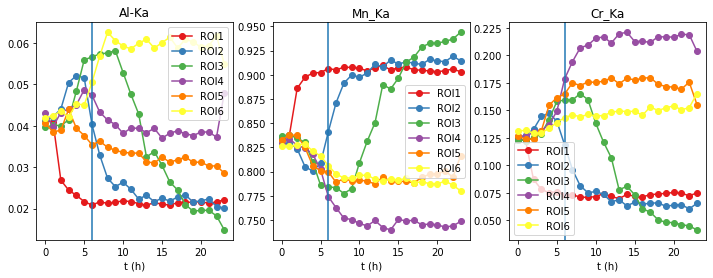

In [13]:
from matplotlib import cm
element_choice =['Cr_Ka', 'Mn_Ka']  
hour = 6
hour_idx = np.argmin(np.abs(hour-hours))

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(12,4))
axs = fig.subplots(1,3)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[0:3]):
    for idx2, roi in enumerate(list(df.index)):

        axs[idx1].plot(hours,df[element][roi]/df['total'][roi], '-o', label=roi, color=cmap[idx2])
    axs[idx1].set_title(element)
    axs[idx1].set_xlabel('t (h)')
    axs[idx1].legend()
    axs[idx1].axvline(hours[hour_idx])



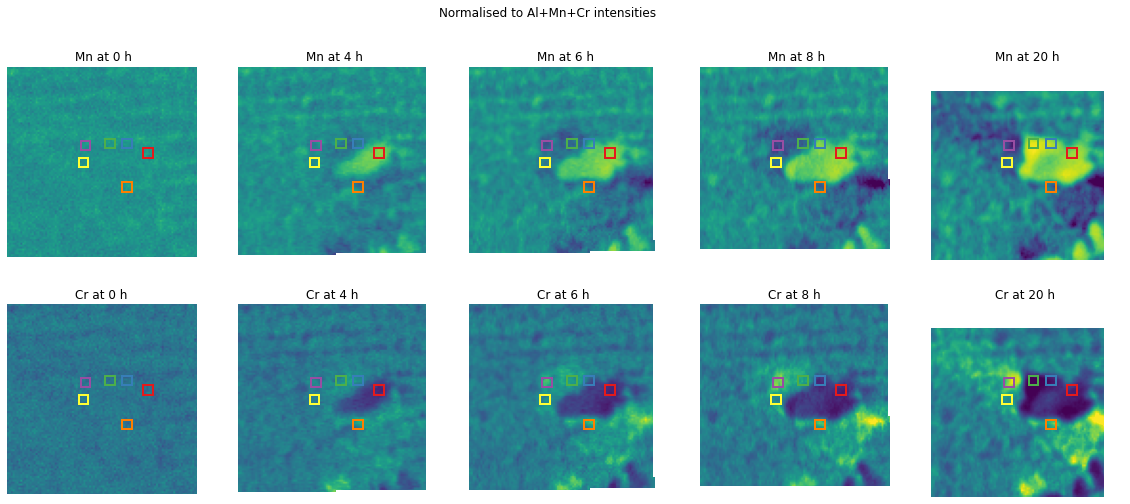

In [14]:
images['total'] = np.zeros(shape=(len(hours),) + images['Al-Ka'][0].shape ) 
for element in list(images.keys())[0:-1]:
    

    for h in range(0,len(hours)):
        
        images['total'][h] += images[element][h]
    
hours_choice = np.array([0,4, 6,8,20])

fig = plt.figure(figsize=(20,8))
fig.suptitle('Normalised to Al+Mn+Cr intensities')
axs = fig.subplots(2,len(hours_choice))
for idx, h in enumerate(hours_choice):
    im_to_show = images['Mn_Ka'][h]/images['total'][h]

    axs[0][idx].imshow(im_to_show, vmin=0.7, vmax=0.95)
    axs[0][idx].set_title(f'Mn at {hours[h]} h')
    axs[0][idx].axis('off')
    #axs[0][h].imshow(images['Mn_Ka'][h], vmax=240)
    im_to_show = images['Cr_Ka'][h]/images['total'][h]
    axs[1][idx].imshow(im_to_show,vmin=0.05, vmax=0.25, cmap='viridis' )
    axs[1][idx].axis('off')
    axs[1][idx].set_title(f'Cr at {hours[h]} h ')



    for i, roi in enumerate(rois):
        row_roi = rois[roi][0]
        col_roi = rois[roi][1]
        axs[0][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=2))
        axs[1][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=2))
        

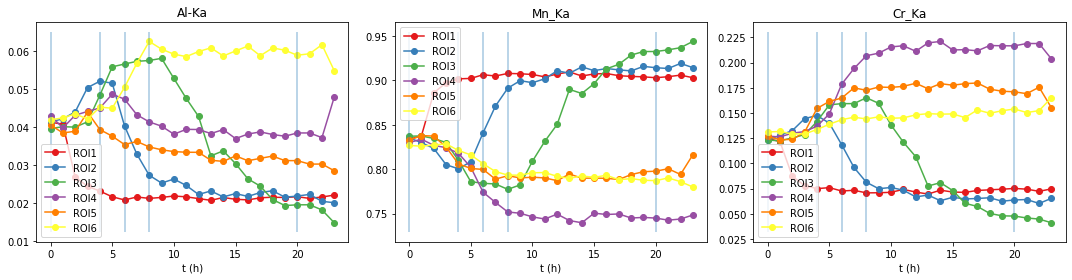

In [15]:
from matplotlib import cm
element_choice =['Cr_Ka', 'Mn_Ka']  


cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(15,4))
axs = fig.subplots(1,3)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[0:3]):
    for idx2, roi in enumerate(list(df.index)):

        axs[idx1].plot(hours,df[element][roi]/df['total'][roi], '-o', label=roi, color=cmap[idx2])
    axs[idx1].set_title(element)
    axs[idx1].set_xlabel('t (h)')
    axs[idx1].legend()
    ylims = axs[idx1].get_ylim()
    axs[idx1].vlines(hours_choice, ylims[0], ylims[1], alpha=0.4)
plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'figures/Mn_Cr_intensity_maps.png'

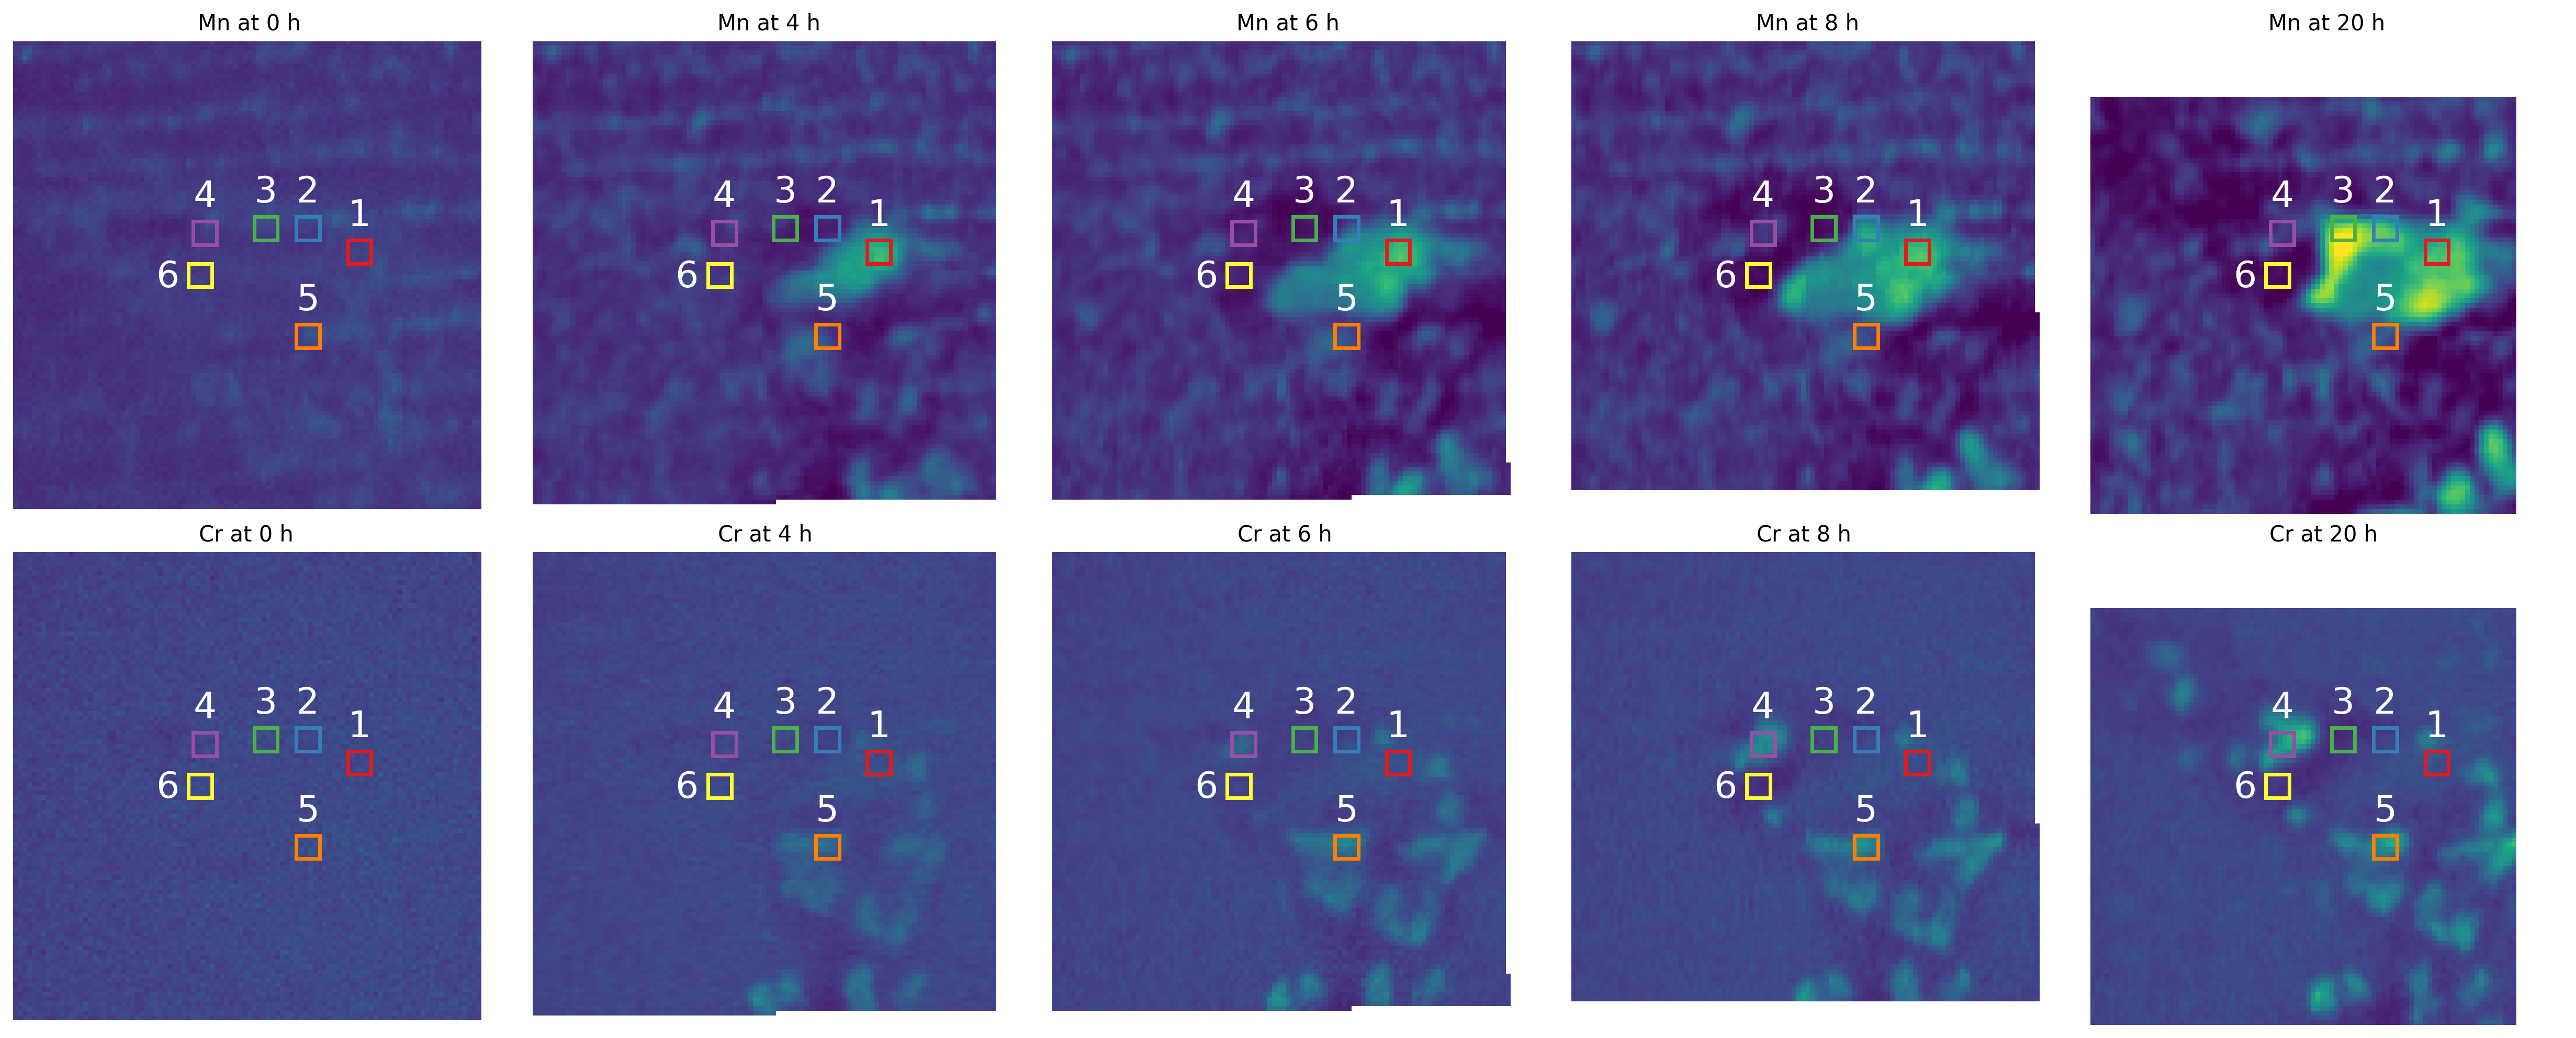

In [16]:

images['total'] = np.zeros(shape=(len(hours),) + images['Al-Ka'][0].shape ) 
for element in list(images.keys())[0:-1]:
    

    for h in range(0,len(hours)):
        
        images['total'][h] += images[element][h]
    
hours_choice = np.array([0,4, 6,8,20])

fig = plt.figure(figsize=(20,8) , dpi=250)
#fig.suptitle('Raw intensities')
axs = fig.subplots(2,len(hours_choice))
for idx, h in enumerate(hours_choice):
    im_to_show = images['Mn_Ka'][h]

    axs[0][idx].imshow(im_to_show, vmin=60, vmax=290)
    axs[0][idx].set_title(f'Mn at {hours[h]} h')
    axs[0][idx].axis('off')
    #axs[0][h].imshow(images['Mn_Ka'][h], vmax=240)
    im_to_show = images['Cr_Ka'][h]
    axs[1][idx].imshow(im_to_show,vmin=6, vmax=50, cmap='viridis' )
    axs[1][idx].axis('off')
    axs[1][idx].set_title(f'Cr at {hours[h]} h ')



    for i, roi in enumerate(rois):
        row_roi = rois[roi][0]
        col_roi = rois[roi][1]
        axs[0][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=2))
        axs[1][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=2))
        if roi == 'ROI6':
            axs[0][idx].text(col_roi-7, row_roi+5, roi.split('ROI')[-1], size=20, color='white')
            axs[1][idx].text(col_roi-7, row_roi+5, roi.split('ROI')[-1], size=20, color='white')
        else:  
            axs[0][idx].text(col_roi, row_roi-3, roi.split('ROI')[-1], size=20, color='white')
            axs[1][idx].text(col_roi, row_roi-3, roi.split('ROI')[-1], size=20, color='white')
plt.tight_layout()
plt.savefig('figures/Mn_Cr_intensity_maps.png', transparent=False, bbox_inches='tight', )
        
        

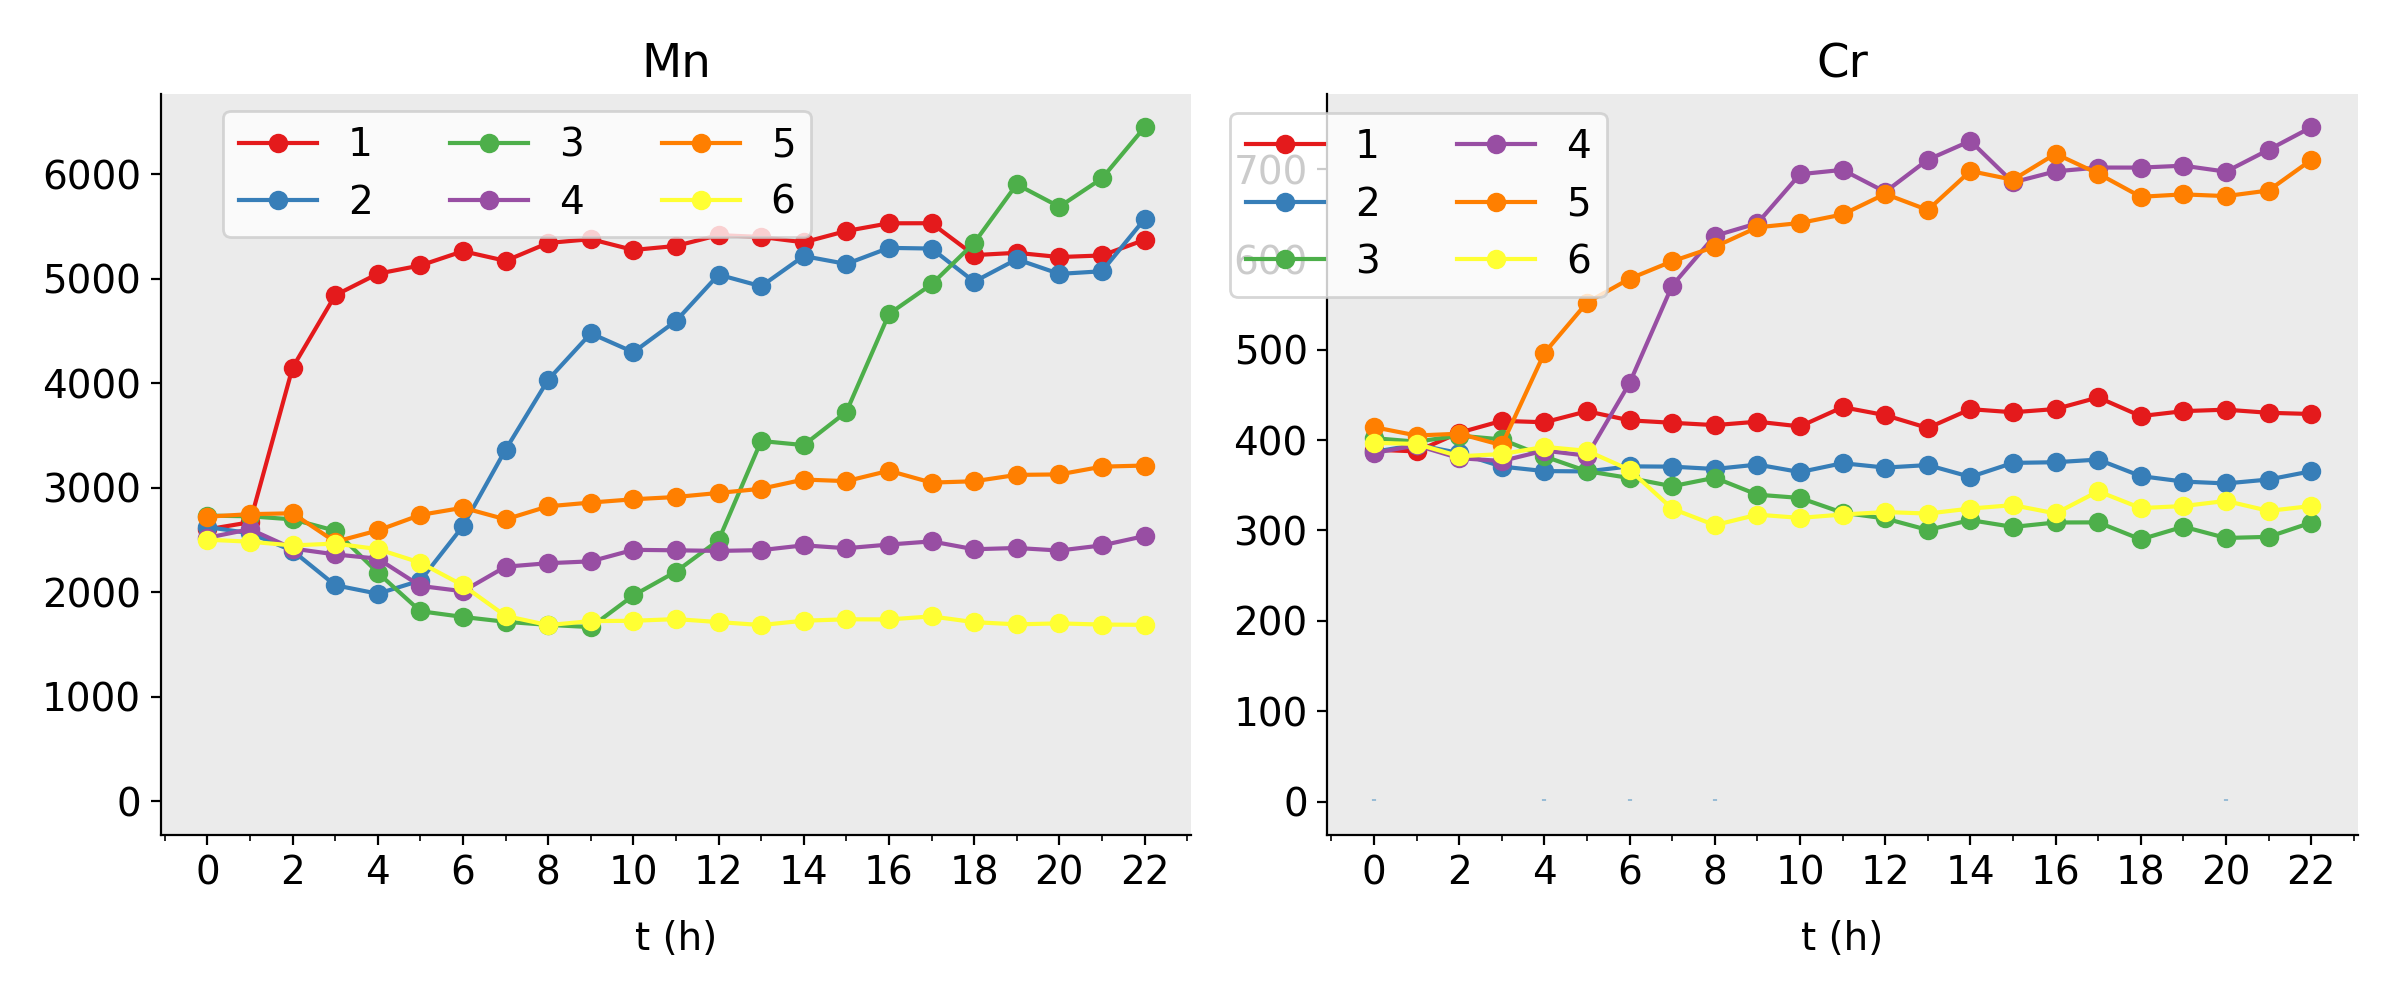

In [19]:
%matplotlib ipympl
from matplotlib import cm
import matplotlib as mpl
element_choice =['Cr_Ka', 'Mn_Ka']  
plt.rcParams['font.size'] = 14

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(12,5), dpi=200)
axs = fig.subplots(1,2)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[1:3]):
    for idx2, roi in enumerate(list(df.index)):

        #axs[idx1].plot(hours[:-1],df[element][roi][:-1]/df[element][roi][0], '-o', label=roi.split('ROI')[-1], color=cmap[idx2])
        axs[idx1].plot(hours[:-1],df[element][roi][:-1], '-o', label=roi.split('ROI')[-1], color=cmap[idx2])
    axs[idx1].set_title(element[0:2])
    axs[idx1].spines['right'].set_visible(False)
    axs[idx1].spines['top'].set_visible(False)
    axs[idx1].set_xlabel('t (h)', labelpad=10)
    axs[idx1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    axs[idx1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    #axs[idx1].set_ylabel('Relative intensity (a.u.)')
    axs[idx1].set_facecolor((0.92, 0.92, 0.92))
    
    ylims = [0.5, 2.5]
    #axs[idx1].set_ylim(ylims)
    axs[idx1].vlines(hours_choice, ylims[0], ylims[1], alpha=0.4)

plt.tight_layout()
axs[0].legend(bbox_to_anchor=(0.65,0.78), ncol=int(len(rois)/2), frameon=True)
axs[1].legend(bbox_to_anchor=(0.29,0.7), ncol=int(len(rois)/3), frameon=True)

#plt.savefig('figures/roi_intensities.png', transparent=False, bbox_inches='tight', )


In [29]:
print(df['Mn_Ka']['ROI4'][6])
print(df['Mn_Ka']['ROI4'][7])
print(df['Mn_Ka']['ROI4'][10])


print(df['Cr_Ka']['ROI4'][6])
print(df['Cr_Ka']['ROI4'][7])
print(df['Cr_Ka']['ROI4'][10])

Mn_incr = df['Mn_Ka']['ROI4'][10]-df['Mn_Ka']['ROI4'][6]
Cr_incr = df['Cr_Ka']['ROI4'][10] - df['Cr_Ka']['ROI4'][6]

print(Mn_incr/Cr_incr)

2008.5211
2243.622
2404.7234
463.26163
571.0993
694.31146
1.7147914


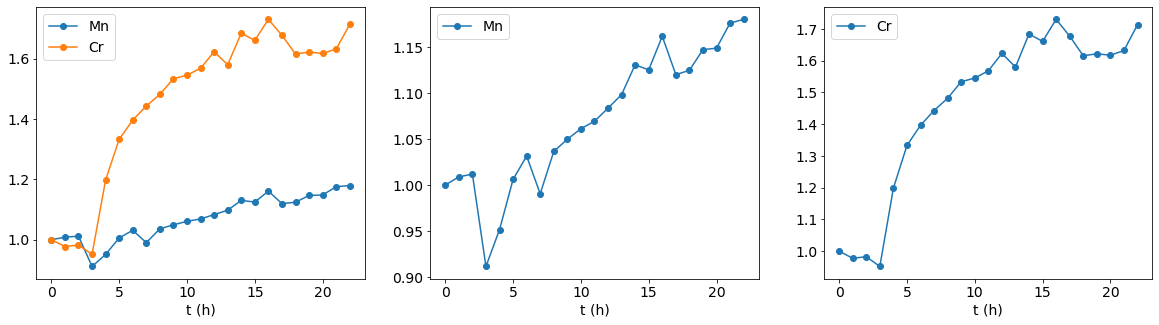

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(hours[:-1],df['Mn_Ka']['ROI5'][:-1]/df['Mn_Ka']['ROI5'][0], '-o', label='Mn')
plt.plot(hours[:-1],df['Cr_Ka']['ROI5'][:-1]/df['Cr_Ka']['ROI5'][0], '-o', label='Cr')
plt.xlabel('t (h)')
plt.legend()
plt.subplot(1,3,2)
plt.plot(hours[:-1],df['Mn_Ka']['ROI5'][:-1]/df['Mn_Ka']['ROI5'][0], '-o', label='Mn')
plt.xlabel('t (h)')
plt.legend()
plt.subplot(1,3,3)
plt.plot(hours[:-1],df['Cr_Ka']['ROI5'][:-1]/df['Cr_Ka']['ROI5'][0], '-o', label='Cr')
plt.xlabel('t (h)')
plt.legend()


Question, how to best present the images? Fractions or raw intensity? \

Big precipitate is Al6Mn and small Cr rich ones are Al12Mn?